In [1]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, make_scorer, f1_score
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier#!pip install xgboost
from collections import Counter

from imblearn.over_sampling import ADASYN # pip install imbalanced-learn
from imblearn.over_sampling import SMOTE # pip install imbalanced-learn
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.base import BaseEstimator, ClassifierMixin

import warnings
warnings.filterwarnings('ignore')

Træningbasis

In [2]:
df_simulated = pd.read_csv(r'C:\Users\jonas\Desktop/FaultFDD_dataprocessed.csv')

In [3]:
# Angiv start og slut tidspunkt for træningsdata
start_time_train = "2024-01-01 00:00:00"  
end_time_train = "2024-12-31 23:00:00"  

# Angiv start og slut tidspunkt for testdata
start_time_test = "2024-01-01 00:00:00"   
end_time_test = "2024-12-31 23:00:00"

# Filter DataFrame for timestamps within the range
df_train_simulated = df_simulated[(df_simulated['Hour'] >= start_time_train) & (df_simulated['Hour'] <= end_time_train)]

df_test_simulated = df_simulated[(df_simulated['Hour'] >= start_time_test) & (df_simulated['Hour'] <= end_time_test)]

# --- Define zones ---
train_zone = 'E'
test_zone = 'J'

# --- Training set ---
X_train_simulated = df_train_simulated[[f'Tai Zone {train_zone}',
                                        f'CO2 Zone {train_zone}',
                                        f'RH Zone {train_zone}',
                                        'WH',
                                        'Tao',
                                        'GHR',
                                        f'Delta_Temp_{train_zone}',
                                        f'T_{train_zone}_rollmean',
                                        f'T_{train_zone}_rollstd',
                                        f'Zscore_{train_zone}',
                                        f'ComfortScore_{train_zone}']]
y_train_simulated = df_train_simulated[f'FDD Zone {train_zone}']

# --- Test set (rename to match training zone) ---
X_test_simulated = df_test_simulated[[f'Tai Zone {test_zone}',
                                      f'CO2 Zone {test_zone}',
                                      f'RH Zone {test_zone}',
                                      'WH',
                                      'Tao',
                                      'GHR',
                                      f'Delta_Temp_{test_zone}',
                                      f'T_{test_zone}_rollmean',
                                      f'T_{test_zone}_rollstd',
                                      f'Zscore_{test_zone}',
                                      f'ComfortScore_{test_zone}']].copy()

# Rename columns to match training zone
X_test_simulated.columns = X_train_simulated.columns

y_test_simulated = df_test_simulated[f'FDD Zone {test_zone}']


Random forest

In [4]:
# Define base Random Forest
rf_base = RandomForestClassifier(
    class_weight={0:2, 1:10, 2:4, 3:10},  # moderate penalty for minority classes
    random_state=42
)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [300, 400,600],
    'max_depth': [6, 8,10],
    'min_samples_leaf': [3,6,10]
}

# Grid search optimizing macro F1
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring=make_scorer(f1_score, average='macro'),
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit on resampled training data
grid_search.fit(X_train_simulated, y_train_simulated)

# Best model
rf_model = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# Predictions
y_pred_train = rf_model.predict(X_train_simulated)
y_pred_test = rf_model.predict(X_test_simulated)

# Evaluation
print("Train Classification Report:\n", classification_report(y_train_simulated, y_pred_train))
print("Test Classification Report:\n", classification_report(y_test_simulated, y_pred_test))

# Feature importances
print("Feature Importances:", rf_model.feature_importances_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 300}
Train Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      8356
         1.0       0.96      0.84      0.90       186
         2.0       0.98      0.41      0.58       133
         3.0       0.89      0.94      0.91        85

    accuracy                           0.99      8760
   macro avg       0.95      0.80      0.85      8760
weighted avg       0.99      0.99      0.98      8760

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      8411
         1.0       0.95      0.61      0.74       146
         2.0       1.00      0.09      0.17       140
         3.0       0.72      0.70      0.71        63

    accuracy                           0.97      8760
   macro avg       0.91      0.60  

In [5]:
print(Counter(y_test_simulated))

Counter({0.0: 8411, 1.0: 146, 2.0: 140, 3.0: 63})


In [39]:
# Store all runs
results = []
for i in range(10):
    rf_model = RandomForestClassifier(
        n_estimators=600,
        max_depth=10,
        min_samples_leaf=5,
        max_samples=0.8,
        class_weight={0:15, 1:5, 2:18, 3:38}
    )
    rf_model.fit(X_train_simulated, y_train_simulated)

    # Get predicted probabilities
    proba = rf_model.predict_proba(X_test_simulated)
    
    # Apply custom thresholding (corrected)
    y_pred_adjusted = []
    for p in proba:
        
        # HIGH CONFIDENCE CLASS 2
        if p[2] > 0.6:
            y_pred_adjusted.append(2)
        
        # HIGH CONFIDENCE CLASS 1
        elif p[1] > 0.6:
            y_pred_adjusted.append(1)
        
        # HIGH CONFIDENCE CLASS 3 (optional but recommended)
        elif p[3] > 0.6:
            y_pred_adjusted.append(3)
        
        # OTHERWISE: fallback to the most probable class among all classes
        else:
            y_pred_adjusted.append(np.argmax(p))
    
    # Classification report using adjusted predictions
    report = classification_report(y_test_simulated, y_pred_adjusted, output_dict=True)
    
    # Store per-class metrics and accuracy
    run_result = {'run': i + 1}
    run_result['accuracy'] = report.get('accuracy', np.nan)
    for label in report:
        if label not in ('accuracy', 'macro avg', 'weighted avg'):
            run_result[f'precision_class_{label}'] = report[label]['precision']
            run_result[f'recall_class_{label}'] = report[label]['recall']
            run_result[f'f1_class_{label}'] = report[label]['f1-score']
            
    results.append(run_result)

# Results as DataFrame
results_df = pd.DataFrame(results)
            
# Summary (mean and std)
summary = results_df.describe().loc[['mean', 'std']]

print("\nSummary (Mean ± Std):")
# print formatted per-column mean ± std (includes accuracy)
for col in summary.columns:
    mean = summary.loc['mean', col]
    std = summary.loc['std', col]
    print(f"{col}: {mean:.3f} ± {std:.3f}")

print("\nAll Per-Class Results:")
print(results_df)



Summary (Mean ± Std):
run: 5.500 ± 3.028
accuracy: 0.971 ± 0.000
precision_class_0.0: 0.973 ± 0.000
recall_class_0.0: 0.998 ± 0.000
f1_class_0.0: 0.986 ± 0.000
precision_class_1.0: 0.946 ± 0.001
recall_class_1.0: 0.357 ± 0.004
f1_class_1.0: 0.518 ± 0.004
precision_class_2.0: 0.992 ± 0.026
recall_class_2.0: 0.075 ± 0.008
f1_class_2.0: 0.139 ± 0.013
precision_class_3.0: 0.660 ± 0.008
recall_class_3.0: 0.729 ± 0.005
f1_class_3.0: 0.693 ± 0.006

All Per-Class Results:
   run  accuracy  precision_class_0.0  recall_class_0.0  f1_class_0.0  \
0    1  0.970548             0.973108          0.998098      0.985444   
1    2  0.970548             0.973327          0.997860      0.985441   
2    3  0.970548             0.973108          0.998098      0.985444   
3    4  0.970434             0.973105          0.997979      0.985385   
4    5  0.970776             0.973333          0.998098      0.985560   
5    6  0.970776             0.973333          0.998098      0.985560   
6    7  0.970662   

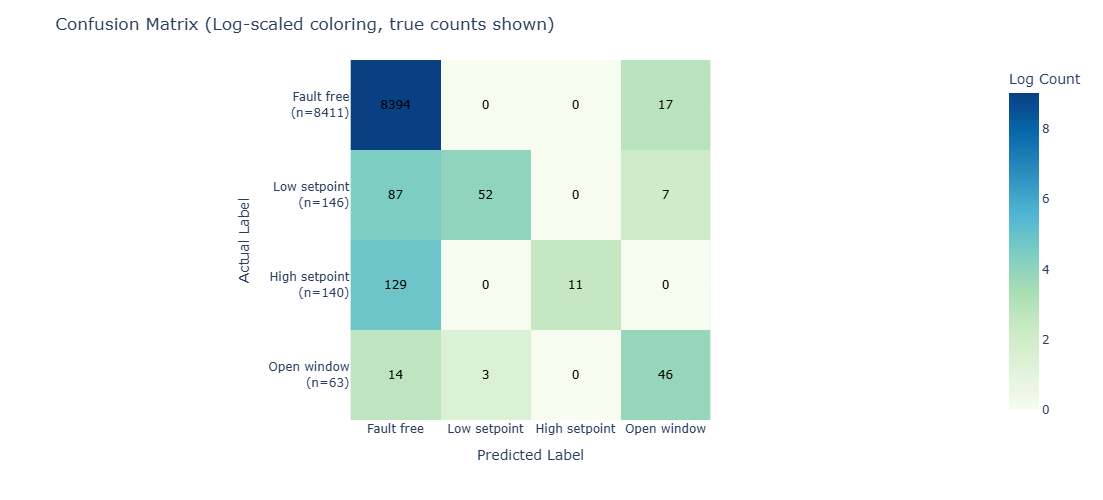

In [40]:
# Define all possible classes
all_classes = [0, 1, 2, 3]
class_names = ["Fault free", "Low setpoint", "High setpoint", "Open window"]

# Compute confusion matrix USING ADJUSTED PREDICTIONS
cm = confusion_matrix(y_test_simulated, y_pred_adjusted, labels=all_classes)

# Compute row totals (actual counts per class)
row_totals = cm.sum(axis=1)
# Append totals to y-axis labels
y_labels = [f"{name}<br>(n={total})" for name, total in zip(class_names, row_totals)]

# Apply log transform for coloring (log1p handles zeros safely)
cm_log = np.log1p(cm)

# Create Plotly heatmap
fig = px.imshow(
    cm_log,
    color_continuous_scale="GnBu",
    labels=dict(x="Predicted", y="Actual", color="Log Count"),
    x=class_names,
    y=y_labels
)

# Add original counts as text
fig.update_traces(
    text=cm,
    texttemplate="%{text}",
    textfont=dict(color="black")
)

# Layout
fig.update_layout(
    title="Confusion Matrix (Log-scaled coloring, true counts shown)",
    xaxis_title="Predicted Label",
    yaxis_title="Actual Label",
    width=700,
    height=500
)

fig.show()


In [38]:
fig = go.Figure()

# Base temperature curve
fig.add_trace(go.Scatter(
    x=df_simulated['Hour'], 
    y=df_simulated['Tai Zone J'], 
    mode='lines', 
    name='Zone faulty operation',
    yaxis='y1'
))

# Convert y_pred to a Pandas Series with the correct index
y_pred_series = pd.Series(y_pred_adjusted, index=y_test_simulated.index)

# Find indices for different cases
correct_1_indices = (y_test_simulated == 1) & (y_pred_series == 1)  # True 1, Pred 1 -> Green
false_negative_indices = (y_test_simulated == 1) & (y_pred_series == 0)  # True 1, Pred 0 -> Red
false_positive_indices = (y_test_simulated == 0) & (y_pred_series == 1)  # True 0, Pred 1 -> Orange

# Extract timestamps
correct_1_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][correct_1_indices]
false_negative_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][false_negative_indices]
false_positive_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][false_positive_indices]

# Extract corresponding temperatures
correct_1_temps = df_simulated.loc[y_test_simulated.index, 'Tai Zone J'][correct_1_indices]
false_negative_temps = df_simulated.loc[y_test_simulated.index, 'Tai Zone J'][false_negative_indices]
false_positive_temps = df_simulated.loc[y_test_simulated.index, 'Tai Zone J'][false_positive_indices]

# Add markers for correct predictions (Green)
fig.add_trace(go.Scatter(
    x=correct_1_timestamps,
    y=correct_1_temps,
    mode='markers',
    marker=dict(color='green', size=10, symbol = 'x'),
    name='Correct (1 predicted as 1)'
))

# Add markers for false negatives (Red)
fig.add_trace(go.Scatter(
    x=false_negative_timestamps,
    y=false_negative_temps,
    mode='markers',
    marker=dict(color='red', size=10, symbol='x'),
    name='False Negative (1 predicted as 0)'
))

# Add markers for false positives (Orange)
fig.add_trace(go.Scatter(
    x=false_positive_timestamps,
    y=false_positive_temps,
    mode='markers',
    marker=dict(color='orange', size=10, symbol='x'),
    name='False Positive (0 predicted as 1)'
))

#Second fault
# Find indices for different cases
correct_2_indices = (y_test_simulated == 2) & (y_pred_series == 2)  # True 2, Pred 2 -> Blue
false_negative_indices = (y_test_simulated == 2) & (y_pred_series == 0)  # True 2, Pred 0 -> Purple
false_positive_indices = (y_test_simulated == 0) & (y_pred_series == 2)  # True 0, Pred 2 -> Pink

# Extract timestamps
correct_2_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][correct_2_indices]
false_negative_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][false_negative_indices]
false_positive_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][false_positive_indices]

# Extract corresponding temperatures
correct_2_temps = df_simulated.loc[y_test_simulated.index, 'Tai Zone J'][correct_2_indices]
false_negative_temps = df_simulated.loc[y_test_simulated.index, 'Tai Zone J'][false_negative_indices]
false_positive_temps = df_simulated.loc[y_test_simulated.index, 'Tai Zone J'][false_positive_indices]

# Add markers for correct predictions (blue)
fig.add_trace(go.Scatter(
    x=correct_2_timestamps,
    y=correct_2_temps,
    mode='markers',
    marker=dict(color='springgreen', size=10, symbol = 'circle'),
    name='Correct (2 predicted as 2)'
))

# Add markers for false negatives (purple)
fig.add_trace(go.Scatter(
    x=false_negative_timestamps,
    y=false_negative_temps,
    mode='markers',
    marker=dict(color='lightcoral', size=10, symbol='circle'),
    name='False Negative (0 predicted as 2)'
))

# Add markers for false positives (pink)
fig.add_trace(go.Scatter(
    x=false_positive_timestamps,
    y=false_positive_temps,
    mode='markers',
    marker=dict(color='bisque', size=10, symbol='circle'),
    name='False Positive (2 predicted as 0)'
))

#third
# Find indices for different cases
correct_3_indices = (y_test_simulated == 3) & (y_pred_series == 3)  # True 3, Pred 3 -> Blue
false_negative_indices = (y_test_simulated == 3) & (y_pred_series == 0)  # True 3, Pred 0 -> Purple
false_positive_indices = (y_test_simulated == 0) & (y_pred_series == 3)  # True 0, Pred 3 -> Pink

# Extract timestamps
correct_3_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][correct_3_indices]
false_negative_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][false_negative_indices]
false_positive_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][false_positive_indices]

# Extract corresponding temperatures
correct_3_temps = df_simulated.loc[y_test_simulated.index, 'Tai Zone J'][correct_3_indices]
false_negative_temps = df_simulated.loc[y_test_simulated.index, 'Tai Zone J'][false_negative_indices]
false_positive_temps = df_simulated.loc[y_test_simulated.index, 'Tai Zone J'][false_positive_indices]

# Add markers for correct predictions (blue)
fig.add_trace(go.Scatter(
    x=correct_3_timestamps,
    y=correct_3_temps,
    mode='markers',
    marker=dict(color='darkgreen', size=10, symbol = 'triangle-up'),
    name='Correct (3 predicted as 3)'
))

# Add markers for false negatives (purple)
fig.add_trace(go.Scatter(
    x=false_negative_timestamps,
    y=false_negative_temps,
    mode='markers',
    marker=dict(color='darkred', size=10, symbol='triangle-up'),
    name='False Negative (0 predicted as 3)'
))

# Add markers for false positives (pink)
fig.add_trace(go.Scatter(
    x=false_positive_timestamps,
    y=false_positive_temps,
    mode='markers',
    marker=dict(color='darkgoldenrod', size=10, symbol='triangle-up'),
    name='False Positive (3 predicted as 0)'
))


# Customize layout
fig.update_layout(
    title="Temperatures with faulty operation in zone E & Prediction Markers",
    xaxis_title="Time",
    yaxis_title="Temperature (°C)",
    legend_title="Legend",
    template="plotly"
)

# Show the plot
fig.show()

In [4]:
# Initialize the XGBoost Classifier
xgb_model = XGBClassifier()

# Train the model
xgb_model.fit(X_train_simulated, y_train_simulated)

# Make predictions
y_pred_train = xgb_model.predict(X_train_simulated)
y_pred = xgb_model.predict(X_test_simulated)

# Evaluate the model
print("Accuracy on Train Set:", accuracy_score(y_train_simulated, y_pred_train))
print("Train Report:\n", classification_report(y_train_simulated, y_pred_train))
print()
print("Accuracy on Test Set:", accuracy_score(y_test_simulated, y_pred))
print("\nClassification Report:\n", classification_report(y_test_simulated, y_pred))

print(xgb_model.feature_importances_)

Accuracy on Train Set: 1.0
Train Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8356
         1.0       1.00      1.00      1.00       186
         2.0       1.00      1.00      1.00       133
         3.0       1.00      1.00      1.00        85

    accuracy                           1.00      8760
   macro avg       1.00      1.00      1.00      8760
weighted avg       1.00      1.00      1.00      8760


Accuracy on Test Set: 0.9751141552511415

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      8411
         1.0       0.92      0.52      0.66       146
         2.0       0.66      0.41      0.51       140
         3.0       0.80      0.59      0.68        63

    accuracy                           0.98      8760
   macro avg       0.84      0.63      0.71      8760
weighted avg       0.97      0.98      0.97      8760

[0.06622914 0.0489064

In [10]:
from xgboost import XGBClassifier

class WeightedXGBClassifier(XGBClassifier):
    def __init__(self, custom_class_weights=None, **kwargs):
        super().__init__(**kwargs)
        self.custom_class_weights = custom_class_weights

    def fit(self, X, y, **kwargs):
        if self.custom_class_weights is not None:
            # apply custom weights
            sample_weight = [self.custom_class_weights[cls] for cls in y]
            return super().fit(X, y, sample_weight=sample_weight, **kwargs)
        else:
            return super().fit(X, y, **kwargs)


# Base model
xgb = WeightedXGBClassifier(
    objective='multi:softprob',   # multiclass
    eval_metric='mlogloss',
    use_label_encoder=False,
    tree_method='hist',
    random_state=42
)

# Parameter distributions
param_dist = {
    'n_estimators': randint(100, 800),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 5),
    'min_child_weight': randint(1, 10),

    # Custom class weights as part of the search
    'custom_class_weights': [
        {0: 1, 1: 5,  2: 10, 3: 12},
        {0: 4, 1: 15,  2: 4, 3: 10},
        {0: 2, 1: 15, 2: 8, 3: 10},
        {0: 2, 1: 15, 2: 18, 3: 10}
    ]
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=25,
    scoring='f1_macro',   # better for imbalanced multiclass than accuracy
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit search
random_search.fit(X_train_simulated, y_train_simulated)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best parameters: {'colsample_bytree': np.float64(0.9329770563201687), 'custom_class_weights': {0: 4, 1: 15, 2: 4, 3: 10}, 'gamma': np.float64(0.0038938292050716417), 'learning_rate': np.float64(0.30766346778736525), 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 352, 'subsample': np.float64(0.7727780074568463)}
Best score: 0.6247544353359685


In [5]:
# Store all runs
results = []

for i in range(10):
    xgb_model = XGBClassifier(
        learning_rate = 0.3,
        max_depth = 4,
        min_child_weight = 6,
        n_estimators = 352,
        reg_alpha = 0,
        reg_lambda = 4,
        subsample = 0.75,
        colsample_bytree=0.7,
        gamma=5,
        max_delta_step = 1,
        random_state = i
    )
    custom_class_weights = {
        0: 6.0,   # Fault free
        1: 9.0,  # Low setpoint
        2: 3.0,  # High setpoint
        3: 16.0   # Open window
    }

    # Map weights to each sample in training data
    sample_weights = np.array([custom_class_weights[label] for label in y_train_simulated])

    # Fit model with custom sample weights
    xgb_model.fit(X_train_simulated, y_train_simulated, sample_weight=sample_weights)

    # Get probabilities
    y_proba = xgb_model.predict_proba(X_test_simulated)

    # Report
    report = classification_report(y_test_simulated, y_pred, output_dict=True)

    # Store per-class metrics
    run_result = {'run': i + 1}
    run_result['accuracy'] = report.get('accuracy', np.nan)
    for label in report:
        if label not in ('accuracy', 'macro avg', 'weighted avg'):
            run_result[f'precision_class_{label}'] = report[label]['precision']
            run_result[f'recall_class_{label}'] = report[label]['recall']
            run_result[f'f1_class_{label}'] = report[label]['f1-score']

    results.append(run_result)


In [8]:
   # Per-class thresholds to reduce false positives
   custom_thresholds = {
       0: 0.0,   # Fault free (always allowed)
       1: 0.6,  # Low setpoint
       2: 0.6,  # High setpoint
       3: 0.60   # Open window
   }

   # Apply thresholds
   y_pred = []
   for probs in y_proba:
       probs = probs / probs.sum()  # normalize just in case
       best_class = np.argmax(probs)
       if probs[best_class] < custom_thresholds[best_class]:
           best_class = 0  # fallback to fault free
       y_pred.append(best_class)
   y_pred = np.array(y_pred)

# Results as DataFrame
results_df = pd.DataFrame(results)

# Summary (mean and std)
summary = results_df.describe().loc[['mean', 'std']]


Summary (Mean ± Std):
          run  accuracy  precision_class_0.0  recall_class_0.0  f1_class_0.0  \
mean  5.50000  0.975114         9.798666e-01      9.952443e-01      0.987496   
std   3.02765  0.000000         1.170278e-16      2.340556e-16      0.000000   

      precision_class_1.0  recall_class_1.0  f1_class_1.0  \
mean         9.156627e-01      5.205479e-01  6.637555e-01   
std          1.170278e-16      1.170278e-16  1.170278e-16   

      precision_class_2.0  recall_class_2.0  f1_class_2.0  \
mean             0.659091      4.142857e-01  5.087719e-01   
std              0.000000      5.851389e-17  1.170278e-16   

      precision_class_3.0  recall_class_3.0  f1_class_3.0  
mean         8.043478e-01      5.873016e-01      0.678899  
std          2.340556e-16      1.170278e-16      0.000000  

All Per-Class Results:
   run  accuracy  precision_class_0.0  recall_class_0.0  f1_class_0.0  \
0    1  0.975114             0.979867          0.995244      0.987496   
1    2  0.975114  

In [10]:
# Define all possible classes
all_classes = [0, 1, 2, 3]  
class_names = ["Fault free", "Low setpoint", "High setpoint", "Open window"]

# Compute confusion matrix
cm = confusion_matrix(y_test_simulated, y_pred, labels=all_classes)

# Compute row totals (actual counts per class)
row_totals = cm.sum(axis=1)

# Append totals to y-axis labels
y_labels = [f"{name}<br>(n={total})" for name, total in zip(class_names, row_totals)]

# Apply log transform for coloring (log1p handles zeros safely)
cm_log = np.log1p(cm)

# Create Plotly heatmap
fig = px.imshow(
    cm_log,
    color_continuous_scale="GnBu",
    labels=dict(x="Predicted", y="Actual", color="Log Count"),
    x=class_names,
    y=y_labels
)

# Add original counts as text
fig.update_traces(
    text=cm,  # original numbers
    texttemplate="%{text}",  # show those numbers
    textfont=dict(color="black")  # ensure visibility
)

# Layout
fig.update_layout(
    title="Confusion Matrix (Log-scaled coloring, true counts shown)",
    xaxis_title="Predicted Label",
    yaxis_title="Actual Label",
    width=700,
    height=500
)

fig.show()

print("\nSummary (Mean ± Std):")
print(summary)

print("\nAll Per-Class Results:")
print(results_df)


Summary (Mean ± Std):
          run  accuracy  precision_class_0.0  recall_class_0.0  f1_class_0.0  \
mean  5.50000  0.975114         9.798666e-01      9.952443e-01      0.987496   
std   3.02765  0.000000         1.170278e-16      2.340556e-16      0.000000   

      precision_class_1.0  recall_class_1.0  f1_class_1.0  \
mean         9.156627e-01      5.205479e-01  6.637555e-01   
std          1.170278e-16      1.170278e-16  1.170278e-16   

      precision_class_2.0  recall_class_2.0  f1_class_2.0  \
mean             0.659091      4.142857e-01  5.087719e-01   
std              0.000000      5.851389e-17  1.170278e-16   

      precision_class_3.0  recall_class_3.0  f1_class_3.0  
mean         8.043478e-01      5.873016e-01      0.678899  
std          2.340556e-16      1.170278e-16      0.000000  

All Per-Class Results:
   run  accuracy  precision_class_0.0  recall_class_0.0  f1_class_0.0  \
0    1  0.975114             0.979867          0.995244      0.987496   
1    2  0.975114  

In [35]:
fig = go.Figure()

# Base temperature curve
fig.add_trace(go.Scatter(
    x=df_simulated['Hour'], 
    y=df_simulated['Tai Zone J'], 
    mode='lines', 
    name='Zone faulty operation',
    yaxis='y1'
))

# Convert y_pred to a Pandas Series with the correct index
y_pred_series = pd.Series(y_pred, index=y_test_simulated.index)

# Find indices for different cases
correct_1_indices = (y_test_simulated == 1) & (y_pred_series == 1)  # True 1, Pred 1 -> Green
false_negative_indices = (y_test_simulated == 1) & (y_pred_series == 0)  # True 1, Pred 0 -> Red
false_positive_indices = (y_test_simulated == 0) & (y_pred_series == 1)  # True 0, Pred 1 -> Orange

# Extract timestamps
correct_1_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][correct_1_indices]
false_negative_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][false_negative_indices]
false_positive_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][false_positive_indices]

# Extract corresponding temperatures
correct_1_temps = df_simulated.loc[y_test_simulated.index, 'Tai Zone J'][correct_1_indices]
false_negative_temps = df_simulated.loc[y_test_simulated.index, 'Tai Zone J'][false_negative_indices]
false_positive_temps = df_simulated.loc[y_test_simulated.index, 'Tai Zone J'][false_positive_indices]

# Add markers for correct predictions (Green)
fig.add_trace(go.Scatter(
    x=correct_1_timestamps,
    y=correct_1_temps,
    mode='markers',
    marker=dict(color='green', size=10, symbol = 'x'),
    name='Correct (1 predicted as 1)'
))

# Add markers for false negatives (Red)
fig.add_trace(go.Scatter(
    x=false_negative_timestamps,
    y=false_negative_temps,
    mode='markers',
    marker=dict(color='red', size=10, symbol='x'),
    name='False Negative (0 predicted as 1)'
))

# Add markers for false positives (Orange)
fig.add_trace(go.Scatter(
    x=false_positive_timestamps,
    y=false_positive_temps,
    mode='markers',
    marker=dict(color='orange', size=10, symbol='x'),
    name='False Positive (1 predicted as 0)'
))

#Second fault
# Find indices for different cases
correct_2_indices = (y_test_simulated == 2) & (y_pred_series == 2)  # True 2, Pred 2 -> Blue
false_negative_indices = (y_test_simulated == 2) & (y_pred_series == 0)  # True 2, Pred 0 -> Purple
false_positive_indices = (y_test_simulated == 0) & (y_pred_series == 2)  # True 0, Pred 2 -> Pink

# Extract timestamps
correct_2_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][correct_2_indices]
false_negative_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][false_negative_indices]
false_positive_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][false_positive_indices]

# Extract corresponding temperatures
correct_2_temps = df_simulated.loc[y_test_simulated.index, 'Tai Zone J'][correct_2_indices]
false_negative_temps = df_simulated.loc[y_test_simulated.index, 'Tai Zone J'][false_negative_indices]
false_positive_temps = df_simulated.loc[y_test_simulated.index, 'Tai Zone J'][false_positive_indices]

# Add markers for correct predictions (blue)
fig.add_trace(go.Scatter(
    x=correct_2_timestamps,
    y=correct_2_temps,
    mode='markers',
    marker=dict(color='springgreen', size=10, symbol = 'circle'),
    name='Correct (2 predicted as 2)'
))

# Add markers for false negatives (purple)
fig.add_trace(go.Scatter(
    x=false_negative_timestamps,
    y=false_negative_temps,
    mode='markers',
    marker=dict(color='lightcoral', size=10, symbol='circle'),
    name='False Negative (0 predicted as 2)'
))

# Add markers for false positives (pink)
fig.add_trace(go.Scatter(
    x=false_positive_timestamps,
    y=false_positive_temps,
    mode='markers',
    marker=dict(color='bisque', size=10, symbol='circle'),
    name='False Positive (2 predicted as 0)'
))

#Second third
# Find indices for different cases
correct_3_indices = (y_test_simulated == 3) & (y_pred_series == 3)  # True 3, Pred 3 -> Blue
false_negative_indices = (y_test_simulated == 3) & (y_pred_series == 0)  # True 3, Pred 0 -> Purple
false_positive_indices = (y_test_simulated == 0) & (y_pred_series == 3)  # True 0, Pred 3 -> Pink

# Extract timestamps
correct_3_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][correct_3_indices]
false_negative_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][false_negative_indices]
false_positive_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][false_positive_indices]

# Extract corresponding temperatures
correct_3_temps = df_simulated.loc[y_test_simulated.index, 'Tai Zone J'][correct_3_indices]
false_negative_temps = df_simulated.loc[y_test_simulated.index, 'Tai Zone J'][false_negative_indices]
false_positive_temps = df_simulated.loc[y_test_simulated.index, 'Tai Zone J'][false_positive_indices]

# Add markers for correct predictions (blue)
fig.add_trace(go.Scatter(
    x=correct_3_timestamps,
    y=correct_3_temps,
    mode='markers',
    marker=dict(color='darkgreen', size=10, symbol = 'triangle-up'),
    name='Correct (3 predicted as 3)'
))

# Add markers for false negatives (purple)
fig.add_trace(go.Scatter(
    x=false_negative_timestamps,
    y=false_negative_temps,
    mode='markers',
    marker=dict(color='darkred', size=10, symbol='triangle-up'),
    name='False Negative (0 predicted as 3)'
))

# Add markers for false positives (pink)
fig.add_trace(go.Scatter(
    x=false_positive_timestamps,
    y=false_positive_temps,
    mode='markers',
    marker=dict(color='darkgoldenrod', size=10, symbol='triangle-up'),
    name='False Positive (3 predicted as 0)'
))


# Customize layout
fig.update_layout(
    title="Temperatures with faulty operation in zone J & Prediction Markers",
    xaxis_title="Time",
    yaxis_title="Temperature (°C)",
    legend_title="Legend",
    template="plotly"
)

# Show the plot
fig.show()

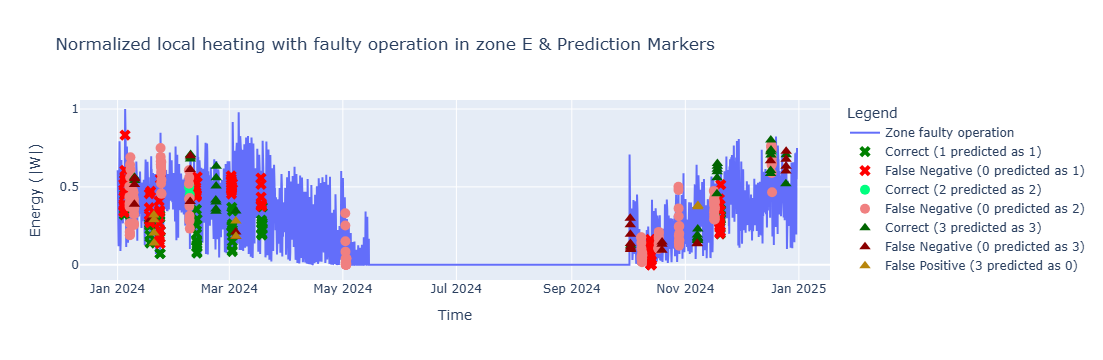

In [15]:
fig = go.Figure()

# Base temperature curve
fig.add_trace(go.Scatter(
    x=df_simulated['Hour'], 
    y=df_simulated['WH'], 
    mode='lines', 
    name='Zone faulty operation',
    yaxis='y1'
))

# Convert y_pred to a Pandas Series with the correct index
y_pred_series = pd.Series(y_pred, index=y_test_simulated.index)

# Find indices for different cases
correct_1_indices = (y_test_simulated == 1) & (y_pred_series == 1)  # True 1, Pred 1 -> Green
false_negative_indices = (y_test_simulated == 1) & (y_pred_series == 0)  # True 1, Pred 0 -> Red
false_positive_indices = (y_test_simulated == 0) & (y_pred_series == 1)  # True 0, Pred 1 -> Orange

# Extract timestamps
correct_1_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][correct_1_indices]
false_negative_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][false_negative_indices]
false_positive_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][false_positive_indices]

# Extract corresponding temperatures
correct_1_temps = df_simulated.loc[y_test_simulated.index, 'WH'][correct_1_indices]
false_negative_temps = df_simulated.loc[y_test_simulated.index, 'WH'][false_negative_indices]
false_positive_temps = df_simulated.loc[y_test_simulated.index, 'WH'][false_positive_indices]

# Add markers for correct predictions (Green)
fig.add_trace(go.Scatter(
    x=correct_1_timestamps,
    y=correct_1_temps,
    mode='markers',
    marker=dict(color='green', size=10, symbol = 'x'),
    name='Correct (1 predicted as 1)'
))

# Add markers for false negatives (Red)
fig.add_trace(go.Scatter(
    x=false_negative_timestamps,
    y=false_negative_temps,
    mode='markers',
    marker=dict(color='red', size=10, symbol='x'),
    name='False Negative (0 predicted as 1)'
))

# Add markers for false positives (Orange)
fig.add_trace(go.Scatter(
    x=false_positive_timestamps,
    y=false_positive_temps,
    mode='markers',
    marker=dict(color='orange', size=10, symbol='x'),
    name='False Positive (1 predicted as 0)'
))

#Second fault
# Find indices for different cases
correct_2_indices = (y_test_simulated == 2) & (y_pred_series == 2)  # True 2, Pred 2 -> Blue
false_negative_indices = (y_test_simulated == 2) & (y_pred_series == 0)  # True 2, Pred 0 -> Purple
false_positive_indices = (y_test_simulated == 0) & (y_pred_series == 2)  # True 0, Pred 2 -> Pink

# Extract timestamps
correct_2_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][correct_2_indices]
false_negative_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][false_negative_indices]
false_positive_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][false_positive_indices]

# Extract corresponding temperatures
correct_2_temps = df_simulated.loc[y_test_simulated.index, 'WH'][correct_2_indices]
false_negative_temps = df_simulated.loc[y_test_simulated.index, 'WH'][false_negative_indices]
false_positive_temps = df_simulated.loc[y_test_simulated.index, 'WH'][false_positive_indices]

# Add markers for correct predictions (blue)
fig.add_trace(go.Scatter(
    x=correct_2_timestamps,
    y=correct_2_temps,
    mode='markers',
    marker=dict(color='springgreen', size=10, symbol = 'circle'),
    name='Correct (2 predicted as 2)'
))

# Add markers for false negatives (purple)
fig.add_trace(go.Scatter(
    x=false_negative_timestamps,
    y=false_negative_temps,
    mode='markers',
    marker=dict(color='lightcoral', size=10, symbol='circle'),
    name='False Negative (0 predicted as 2)'
))

# Add markers for false positives (pink)
fig.add_trace(go.Scatter(
    x=false_positive_timestamps,
    y=false_positive_temps,
    mode='markers',
    marker=dict(color='bisque', size=10, symbol='circle'),
    name='False Positive (2 predicted as 0)'
))

#Second third
# Find indices for different cases
correct_3_indices = (y_test_simulated == 3) & (y_pred_series == 3)  # True 3, Pred 3 -> Blue
false_negative_indices = (y_test_simulated == 3) & (y_pred_series == 0)  # True 3, Pred 0 -> Purple
false_positive_indices = (y_test_simulated == 0) & (y_pred_series == 3)  # True 0, Pred 3 -> Pink

# Extract timestamps
correct_3_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][correct_3_indices]
false_negative_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][false_negative_indices]
false_positive_timestamps = df_simulated.loc[y_test_simulated.index, 'Hour'][false_positive_indices]

# Extract corresponding temperatures
correct_3_temps = df_simulated.loc[y_test_simulated.index, 'WH'][correct_3_indices]
false_negative_temps = df_simulated.loc[y_test_simulated.index, 'WH'][false_negative_indices]
false_positive_temps = df_simulated.loc[y_test_simulated.index, 'WH'][false_positive_indices]

# Add markers for correct predictions (blue)
fig.add_trace(go.Scatter(
    x=correct_3_timestamps,
    y=correct_3_temps,
    mode='markers',
    marker=dict(color='darkgreen', size=10, symbol = 'triangle-up'),
    name='Correct (3 predicted as 3)'
))

# Add markers for false negatives (purple)
fig.add_trace(go.Scatter(
    x=false_negative_timestamps,
    y=false_negative_temps,
    mode='markers',
    marker=dict(color='darkred', size=10, symbol='triangle-up'),
    name='False Negative (0 predicted as 3)'
))

# Add markers for false positives (pink)
fig.add_trace(go.Scatter(
    x=false_positive_timestamps,
    y=false_positive_temps,
    mode='markers',
    marker=dict(color='darkgoldenrod', size=10, symbol='triangle-up'),
    name='False Positive (3 predicted as 0)'
))


# Customize layout
fig.update_layout(
    title="Normalized local heating with faulty operation in zone E & Prediction Markers",
    xaxis_title="Time",
    yaxis_title="Energy (|W|)",
    legend_title="Legend",
    template="plotly"
)

# Show the plot
fig.show()